# 4. Top-N Simulations from Actual Experimental Data

This notebook loads an existing Beer1pos data, runs it through the simulator and compares the simulated results to the initial input data. The results here correspond to Section 3.2 in the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import pymzml

In [3]:
import sys
sys.path.append('..')

In [4]:
from vimms.Roi import RoiToChemicalCreator, make_roi
from vimms.DataGenerator import DataSource, PeakSampler, get_spectral_feature_database
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController
from vimms.PlotsForPaper import count_stuff, plot_num_scans, match_peaklist, check_found_matches, \
plot_matched_intensities, plot_matched_precursors
from vimms.Common import *

In [5]:
set_log_level_debug()

## 1. Parameters

In [6]:
base_dir = 'example_data'
mzml_path = os.path.join(base_dir, 'beers', 'fragmentation', 'mzML')
file_name = 'Beer_multibeers_1_T10_POS.mzML'

experiment_name = 'mzml_compare'
experiment_out_dir = os.path.join(base_dir, 'results', experiment_name)

In [7]:
min_rt = 0
max_rt = 1441

In [8]:
kde_min_ms1_intensity = 0 # min intensity to be selected for kdes
kde_min_ms2_intensity = 0

### a. ROI extraction parameters

In [9]:
roi_mz_tol = 10
roi_min_length = 1
roi_min_intensity = 0
roi_start_rt = min_rt
roi_stop_rt = max_rt

### b. Top-N parameters

In [10]:
isolation_window = 1   # the isolation window in Dalton around a selected precursor ion
ionisation_mode = POSITIVE
N = 10
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 1.75E5 # minimum ms1 intensity to fragment

In [11]:
mzml_out = os.path.join(experiment_out_dir, 'simulated.mzML')

## 2. Train densities

In [12]:
ds = DataSource()
ds.load_data(mzml_path, file_name=file_name)

INFO   : DataSource                     : Loading Beer_multibeers_1_T10_POS.mzML


In [13]:
bandwidth_mz_intensity_rt=1.0
bandwidth_n_peaks=1.0
ps = get_spectral_feature_database(ds, file_name, kde_min_ms1_intensity, kde_min_ms2_intensity, min_rt, max_rt,
               bandwidth_mz_intensity_rt, bandwidth_n_peaks)

DEBUG  : PeakSampler                    : Extracted 7647 MS2 scans
DEBUG  : PeakSampler                    : Computing parent intensity proportions
DEBUG  : PeakSampler                    : Extracting scan durations
DEBUG  : PeakSampler                    : Training KDEs for ms_level=1
DEBUG  : PeakSampler                    : Retrieving mz_intensity_rt values from <vimms.DataGenerator.DataSource object at 0x00000172559A4630>
INFO   : DataSource                     : Using values from scans
DEBUG  : PeakSampler                    : Retrieving n_peaks values from <vimms.DataGenerator.DataSource object at 0x00000172559A4630>
DEBUG  : PeakSampler                    : Training KDEs for ms_level=2
DEBUG  : PeakSampler                    : Retrieving mz_intensity_rt values from <vimms.DataGenerator.DataSource object at 0x00000172559A4630>
INFO   : DataSource                     : Using values from scans
DEBUG  : PeakSampler                    : Retrieving n_peaks values from <vimms.DataGener

## 3. Extract all ROIs

In [14]:
mzml_file = os.path.join(mzml_path, file_name)
good_roi, junk = make_roi(mzml_file, mz_tol=roi_mz_tol, mz_units='ppm', min_length=roi_min_length,
                          min_intensity=roi_min_intensity, start_rt=roi_start_rt, stop_rt=roi_stop_rt)

In [15]:
all_roi = good_roi + junk
len(all_roi)

512540

How many singleton and non-singleton ROIs?

In [16]:
len([roi for roi in all_roi if roi.n == 1])

352967

In [17]:
len([roi for roi in all_roi if roi.n > 1])

159573

Keep only the ROIs that can be fragmented above **min_ms1_intensity threshold**.

In [18]:
min_ms1_intensity

175000.0

In [19]:
keep = []
for roi in all_roi:
    if np.count_nonzero(np.array(roi.intensity_list) > min_ms1_intensity) > 0:
        keep.append(roi)

all_roi = keep
len(keep)

10190

Turn ROIs into chromatograms/chemicals

In [20]:
set_log_level_debug()
rtcc = RoiToChemicalCreator(ps, all_roi)

DEBUG  : RoiToChemicalCreator           :      0/ 10190
INFO   : RoiToChemicalCreator           : Found 10190 ROIs above thresholds


In [21]:
data = rtcc.chemicals
save_obj(data, os.path.join(experiment_out_dir, 'dataset.p'))

Saving <class 'list'> to example_data\results\mzml_compare\dataset.p


## 4. Run Top-N Controller

In [22]:
set_log_level_warning()
pbar = True

In [23]:
mass_spec = IndependentMassSpectrometer(ionisation_mode, data, ps)
controller = TopNController(mass_spec, N, isolation_window, mz_tol,
                            rt_tol, min_ms1_intensity)
controller.run(min_rt, max_rt, pbar)

1441.1996749999914it [01:41, 14.17it/s]                                                                              


In [24]:
controller.write_mzML('my_analysis', mzml_out)

In [25]:
mzml_out

'example_data\\results\\mzml_compare\\simulated.mzML'

## 5. Compare Results

### Load simulated and real data.

In [26]:
simulated_input_file = mzml_out
simulated_mzs, simulated_rts, simulated_intensities, simulated_cumsum_ms1, simulated_cumsum_ms2 = count_stuff(
    simulated_input_file, min_rt, max_rt)

Number of ms1 scans = 1258
Number of ms2 scans = 8619
Total scans = 9877
Number of selected precursors = 8619


In [27]:
real_input_file = mzml_file
real_mzs, real_rts, real_intensities, real_cumsum_ms1, real_cumsum_ms2 = count_stuff(
    real_input_file, min_rt, max_rt)

Number of ms1 scans = 1751
Number of ms2 scans = 7655
Total scans = 9406
Number of selected precursors = 7672


### Plot number of scans

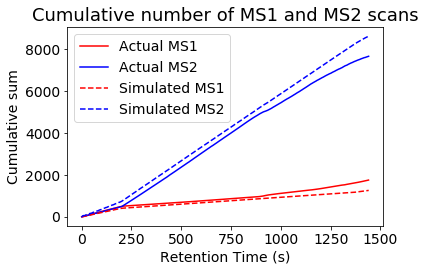

In [28]:
plt.rcParams.update({'font.size': 14})
out_file = os.path.join(base_dir, 'results', 'topN_num_scans.png')
plot_num_scans(real_cumsum_ms1, real_cumsum_ms2, simulated_cumsum_ms1, simulated_cumsum_ms2, out_file)

### Check the number of precursors that could be matched at different m/z and RT tolerances

In [29]:
mz_tol = None # in ppm. if None, then 2 decimal places is used for matching the m/z
rt_tol = 5 # seconds
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

Found 4875/7655 (0.636839)
Real						Simulated
mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5394 intensity 1735726.1927
mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.6714 intensity 1517306.5950
mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8114 intensity 1324472.7979
mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 0.8914 intensity 808759.8595
mz 224.19 rt 1.1375 intensity 395470.6562	mz 224.19 rt 1.3004 intensity 406930.1763
mz 338.34 rt 1.2750 intensity 385685.9688	mz 338.34 rt 1.1644 intensity 415747.1931
mz 116.07 rt 1.4077 intensity 366917.8750	mz 116.07 rt 1.0274 intensity 488422.7070
mz 131.13 rt 1.5412 intensity 322462.5000	mz 131.13 rt 1.4334 intensity 381448.3994
mz 104.11 rt 1.6740 intensity 267410.7188	mz 104.11 rt 1.5724 intensity 329901.3222
mz 228.20 rt 2.0738 intensity 605814.3125	mz 228.20 rt 2.3074 intensity 600740.7569
mz 162.08 rt 2.2073 intensity 955391.5000	mz 162.08 rt 1.7074 intensity 324396.9502
mz 128.95 rt 2.4319 int

In [30]:
mz_tol = None
rt_tol = 10
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

Found 6546/7655 (0.855127)
Real						Simulated
mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5394 intensity 1735726.1927
mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.6714 intensity 1517306.5950
mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8114 intensity 1324472.7979
mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 0.8914 intensity 808759.8595
mz 224.19 rt 1.1375 intensity 395470.6562	mz 224.19 rt 1.3004 intensity 406930.1763
mz 338.34 rt 1.2750 intensity 385685.9688	mz 338.34 rt 1.1644 intensity 415747.1931
mz 116.07 rt 1.4077 intensity 366917.8750	mz 116.07 rt 1.0274 intensity 488422.7070
mz 131.13 rt 1.5412 intensity 322462.5000	mz 131.13 rt 1.4334 intensity 381448.3994
mz 104.11 rt 1.6740 intensity 267410.7188	mz 104.11 rt 1.5724 intensity 329901.3222
mz 228.20 rt 2.0738 intensity 605814.3125	mz 228.20 rt 2.3074 intensity 600740.7569
mz 162.08 rt 2.2073 intensity 955391.5000	mz 162.08 rt 1.7074 intensity 324396.9502
mz 128.95 rt 2.4319 int

In [31]:
mz_tol = None
rt_tol = 15
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

Found 6759/7655 (0.882952)
Real						Simulated
mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5394 intensity 1735726.1927
mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.6714 intensity 1517306.5950
mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8114 intensity 1324472.7979
mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 0.8914 intensity 808759.8595
mz 224.19 rt 1.1375 intensity 395470.6562	mz 224.19 rt 1.3004 intensity 406930.1763
mz 338.34 rt 1.2750 intensity 385685.9688	mz 338.34 rt 1.1644 intensity 415747.1931
mz 116.07 rt 1.4077 intensity 366917.8750	mz 116.07 rt 1.0274 intensity 488422.7070
mz 131.13 rt 1.5412 intensity 322462.5000	mz 131.13 rt 1.4334 intensity 381448.3994
mz 104.11 rt 1.6740 intensity 267410.7188	mz 104.11 rt 1.5724 intensity 329901.3222
mz 228.20 rt 2.0738 intensity 605814.3125	mz 228.20 rt 2.3074 intensity 600740.7569
mz 162.08 rt 2.2073 intensity 955391.5000	mz 162.08 rt 1.7074 intensity 324396.9502
mz 128.95 rt 2.4319 int

### Plot the matches

In [32]:
unmatched_intensities = []
matched_intensities = []
for key, value in list(matches.items()):
    intensity = key[2]
    if value is None:
        unmatched_intensities.append(intensity)
    else:
        matched_intensities.append(intensity)

In [33]:
plt.rcParams.update({'font.size': 18})   

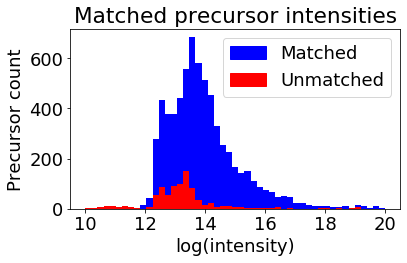

In [34]:
out_file = os.path.join(base_dir, 'results', 'topN_matched_intensities.png')
plot_matched_intensities(matched_intensities, unmatched_intensities, out_file)

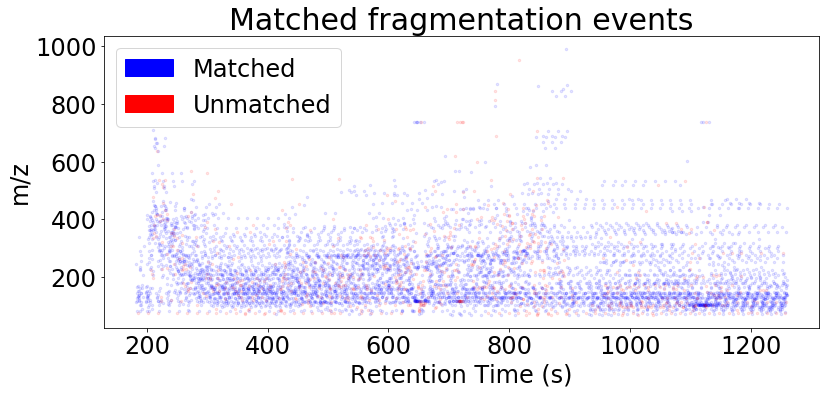

In [35]:
out_file = os.path.join(base_dir, 'results', 'topN_matched_precursors.png')
plot_matched_precursors(matches, 50, 1000, 180, 1260, out_file)